In [215]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix


In [134]:
assess = pd.read_csv("processing/CDS2002/ASSESSMT.csv")
child = pd.read_csv("processing/CDS2002/CHILD.csv")
pcg = pd.read_csv("processing/CDS2002/PCG_CHLD.csv") 
wealth = pd.read_csv("processing/wlth2001/WLTH2001.csv")

In [135]:
fam01 = pd.read_csv("processing/fam2001er/FAM2001ER.csv")
ind = pd.read_csv("processing/ind2017er/IND2017ER.csv")

In [136]:
fam01

,Unnamed: 0,ER17001,ER17002,ER17003,ER17004,ER17005,ER17005B,ER17005C,ER17006,ER17007,...,ER20458,ER20458A,ER20458B,ER20458C,ER20458D,ER20458E,ER20458F,ER20458G,ER20458H,ER20459
0,0,6,1,2280,9,12,54,1,1,0,...,0,9,9,9,9,9,9,9,9,27473
1,1,6,2,2280,9,12,61,1,1,0,...,12,9,9,9,9,9,9,9,9,46353
2,2,6,3,2515,32,37,54,3,1,1,...,0,9,9,9,9,1,9,9,9,1957
3,3,6,4,2515,32,37,79,3,1,0,...,12,0,0,0,0,0,0,0,1,2014
4,4,6,5,2515,32,37,58,2,1,1,...,8,0,9,0,9,0,9,0,9,1181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7401,7401,6,7453,8703,19,24,60,10,2,2,...,0,0,9,0,9,0,9,0,9,4382
7402,7402,6,7454,4970,50,2,59,93,1,2,...,0,0,9,0,0,0,9,0,0,10850
7403,7403,6,7455,8703,29,34,123,63,2,5,...,0,0,9,0,0,0,9,0,0,4144
7404,7404,6,7456,4970,13,18,29,28,2,2,...,0,0,9,0,9,0,9,0,9,24876


In [158]:
assess_cl = assess[["ASMTID01", "ASMTSN01", "Q24LWPR", "Q24APPR"]].rename({"ASMTID01": "fam_id01", "ASMTSN01": "ind_id01", "Q24LWPR": "read_score", "Q24APPR": "math_score"}, axis=1)
child_cl = child[["CHLDID01", "CHLDSN01", "Q23J1"]].rename({"CHLDID01": "fam_id01", "CHLDSN01": "ind_id01", "Q23J1": "race_code"}, axis=1)
ind_cl = ind[["ER33601", "ER33638", "ER33602", "ER34504", "ER34530", "ER34533", "ER34534"]].rename({"ER33601": "fam_id01", "ER33602": "ind_id01", "ER34504": "age_2017", "ER34534": "college_degree"}, axis=1)
wealth_cl = wealth[["S501", "S516", "S517"]].rename({"S501": "fam_id01", "S517": "wealth_w_eq"}, axis=1)
fam01_cl = fam01[["ER17002", "ER17004", "ER18470T", "ER20377C", "ER18470U", "ER20456"]].rename({"ER17002": "fam_id01", "ER20456": "fam_income", "ER20377C": "urban_rural"}, axis=1)
# 2001 family id
ind_cds = ind_cl[ind_cl["ER33638"] == 1]

In [159]:
# get all individuals who participated in the cds in 2001 & responded in 2017
# get their 2001 interview & 2001 sequence codes

In [160]:
temp1 = ind_cds.merge(child_cl, on=["fam_id01", "ind_id01"], how="left")
temp2 = temp1.merge(assess_cl, on=["fam_id01", "ind_id01"], how="left")
temp3 = temp2.merge(fam01_cl, on="fam_id01", how="left")
df = temp3.merge(wealth_cl, on="fam_id01", how="left")
df = df[(df["age_2017"] > 24)]

In [161]:
# degree: 1 yes, 5 no
df["age_2017"].value_counts()

30    199
27    192
25    190
31    180
29    179
26    179
28    170
32    153
33     45
Name: age_2017, dtype: int64

In [174]:
data_df = pd.DataFrame(df[["race_code", "read_score", "math_score", "urban_rural", "fam_income", "wealth_w_eq", "college_degree"]])

In [179]:
def get_race(num):
    if num == 1:
        return "black"
    elif num == 2:
        return "white"
    elif num==3:
        return "hispanic"
    elif num==4:
        return "asian"
    elif num==6:
        return "multi"
    else:
        return None
    
def get_urb_rur(num):
    if num==1:
        return "central_metro_1mil"
    elif num==2:
        return "fringe_metro_1mil"
    elif num==3:
        return "county_metro_250k"
    elif num==4:
        return "country_metro_less"
    elif num==5:
        return "urb_pop_20k_adj_met"
    elif num==6:
        return "urb_pop_20k_nonadj_met"
    elif num==7:
        return "urb_pop_less_adj_met"
    elif num==8:
        return "urb_pop_less_nonadj_met"
    elif num==9:
        return "rural"
    else:
        return None
    
def get_urb_rur_bin(num):
    if num == 1 or num == 2 or num ==3 or num == 4:
        return "met"
    elif num == 5 or num == 6 or num == 7 or num == 8:
        return "urb"
    elif num == 9:
        return "rural"
    else:
        return None
    
def college_grad(num):
    if num == 1:
        return "yes"
    else:
        return "no"

In [180]:
data_df["race"] = list(map(get_race, data_df["race_code"]))
data_df["urb_rur1"] = list(map(get_urb_rur, data_df["urban_rural"]))
data_df["urb_rur2"] = list(map(get_urb_rur_bin, data_df["urban_rural"]))
data_df["college_grad"] = list(map(college_grad, data_df["college_degree"]))

In [181]:
data_df

,race_code,read_score,math_score,urban_rural,fam_income,wealth_w_eq,college_degree,race,urb_rur1,urb_rur2,college_grad
0,2.0,25.0,30.0,7,50880,113050,0,white,urb_pop_less_adj_met,urb,no
1,0.0,3.0,2.0,7,37760,11500,0,None,urb_pop_less_adj_met,urb,no
5,2.0,1.0,8.0,3,16735,48700,0,white,county_metro_250k,met,no
6,2.0,16.0,24.0,3,16735,48700,0,white,county_metro_250k,met,no
9,1.0,84.0,94.0,6,16271,800,5,black,urb_pop_20k_nonadj_met,urb,no
...,...,...,...,...,...,...,...,...,...,...,...
2892,1.0,65.0,37.0,1,25000,28000,5,black,central_metro_1mil,met,no
2895,0.0,28.0,35.0,1,50160,10000,0,None,central_metro_1mil,met,no
2896,0.0,58.0,63.0,1,31749,-15200,5,None,central_metro_1mil,met,no
2898,1.0,25.0,41.0,1,31749,-15200,0,black,central_metro_1mil,met,no


In [182]:
X = data_df[["race", "read_score", "math_score", "fam_income", "wealth_w_eq", "urb_rur2"]]
y = data_df["college_grad"]

In [192]:
len(X["read_score"])

1487

In [201]:
X_fill = X.fillna({"read_score": 50, "math_score": 50})

In [213]:
kfold = StratifiedKFold(shuffle=True, random_state=0)

X_dum = pd.get_dummies(X_fill)

X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

lm = LogisticRegressionCV(cv=kfold)
lm.fit(X_train_scale, y_train);
lm.score(X_train_scale, y_train), lm.score(X_test_scale, y_test)

(0.7333894028595458, 0.7013422818791947)

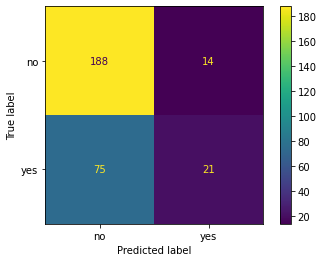

In [217]:
plot_confusion_matrix(lm, X_test_scale, y_test);